# FEM based analysis of cooling a freshly brewed tea 
* The aim of the simulation is to predict the cooling time of tea down to drinking temperature. 
* Additionally, the heat transfer mechanisms of the cooling process are analyzed.
* The simulation of the thermal behaviour of the cup itself is based on the FE-method.
* A mathematical method for reducing the model's degrees of freedom is used to significantly speed up the simulation.

![tea mug](mug.png)

### Create body and surface geometry
* Create the mug body in CAD
* Partition of the surface area in sections that require individual thermal coupling
* E.g. separate the inner mug surface that reaches up to the fill line (see picture below)

### Create coupling surfaces
* Group surfaces with common thermal coupling
* In Salome Meca 
    * Activate the Shaper module
    * Use Features > Group and select Faces as the group-type 
    * Pic all surfaces while holding Shift key
    * After finishing the grouping create a Salome-Geometry using Features > Export to GEOM
    
![mug coupling surfaces](mug_surf_groups_shaper.png)

### Create mesh

* Create tetrahedron mesh
* Export mesh with coupling surface information
* In Salome Meca 
    * Activate the Mesh module
    * Select body geometry in Object Browser
    * Use Mesh > Create Mesh to define mesh properties
    * Select Thedrahedral as Mesh type
    * Select Algorithm and Hypothesis with appropriate parameters
    * Use Mesh > Compute to generate the mesh
    * Rhight click on mesh in Object Browser and select Export > Med file to create a mesh file

![mug mesh](mug_mesh_salome.png)

### Import tools for analysis with Thermca
* Thermca for thermal analysis 
* PyVista for 3D plotting.

In [1]:
from thermca import *
import pyvista as pv
pv.set_jupyter_backend('static')

### Load and check mug mesh

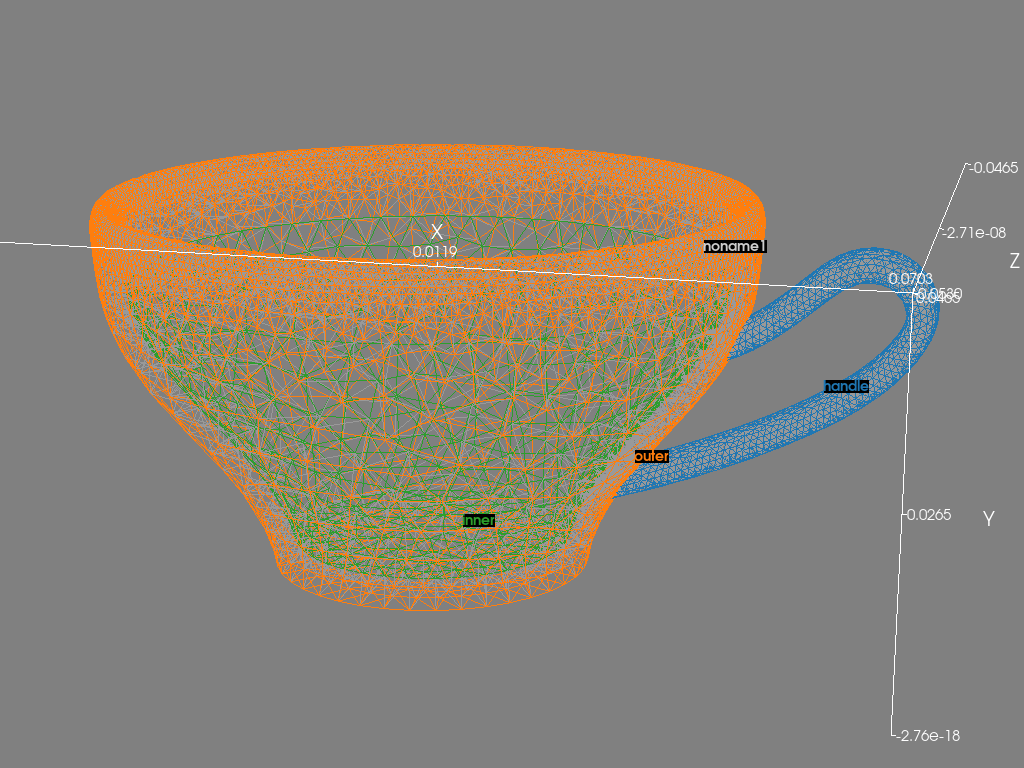

In [2]:
mesh = Mesh.read("mug_salome.med")

def show_thight(plot):
    plot.camera.zoom(1.5)
    plot.show()
    
show_thight(mesh.plot())

To explore the meshes and mesh types in the mesh file print the name and the type of each mesh.
There should be one mesh of type tetra. This is the body consisting of tetrahedrons. The other meshes should be of type triangle. These should be the surfaces of the body which are interfaces for connections in the thermal model.

In [3]:
for name, type_ in zip(mesh.block_names, mesh.block_types):
    print(f'"{name}": {type_}')

"noname1": tetra
"handle": triangle
"outer": triangle
"inner": triangle


### Model creation: elements with known and unknown temperatures

In [4]:
tea_volume =  .000125
env_temp = 20.
boiling_temp = 100.

with Model() as model:
    # Solid state model of mug
    mug = FEPart(
        mesh=mesh,
        matl=solids.porcelain,
        init_temp=env_temp, 
        mor_dof=10, # DOF of coupling surface models that the part model consists of
        name='mug'
    )
    # Tea as material node
    # Material properties are internally used to determine the node heat capacity and the convective heat transfer coefficients connecting the node
    tea = MatlNode(
        matl=fluids.water, 
        init_temp=boiling_temp,
        vol=tea_volume, 
        posn=(.0, .023, 0.),  
        name='tea'
    )
    # Convection and radiation environment as bound (specified) temperature
    conv_radn_sink = BoundNode(
        temp=env_temp,
        posn=(.04, .07, 0.),                    
        name='conv_radn_sink'
    )
    # Evaporation environment as bound temperature
    evap_sink = BoundNode(
        temp=env_temp, 
        posn=(-.04, .07, 0.), 
        name='evap_sink'
    )

### Model creation: thermal transitions

In [5]:
tea_surface = .00562
tea_height = .038
mug_height = .052
emis_room = .8  # emission coefficient room surfaces
emis_mug = .8

with model:
    # Link cup inside with tea
    # Use the temperature dependent convection model of a vertical plate
    # Internally, the temperature dependent material properties get updated and subsequently the film coefficient
    tee_to_mug = FilmLink(
        mug.surf.inner, 
        tea,          
        free_conv.vert_surf(surf_hgt=tea_height),
        matl=fluids.water,
    )       
    # Link cup outside with surroundings by concvection and radiation
    # Film coefficient sum of temperature dependent convection and heat radiation models
    mug_to_env, handle_to_env = FilmLink.multi(         
        [mug.surf.outer, mug.surf.handle],
        conv_radn_sink,
        sum_films(
            free_conv.vert_surf(surf_hgt=mug_height),
            radiation.therm_radn(res_emis=emis_mug*emis_room)
        ),
        matls=fluids.air,
    )    
    # Link tea surface with surroundings by evaporation
    # Temperature dependent evaporation model
    # Because the connected nodes have no surface, they have to be connected by conductance 
    vap_to_env = CondLink(
        tea, 
        evap_sink, 
        evaporation.free_forc_water_to_air(
            vel=0., 
            rel_hum=.6,
            factor=tea_surface
        )
    )
    # Link tea surface with surroundings by convection and radiation
    # Using a fast model that approximates convection and heat radiation of body surfaces in rooms
    tee_to_env = CondLink(
        tea, 
        conv_radn_sink,
        combd_film.conv_radn_room(factor=tea_surface)
    )

### Visual model check

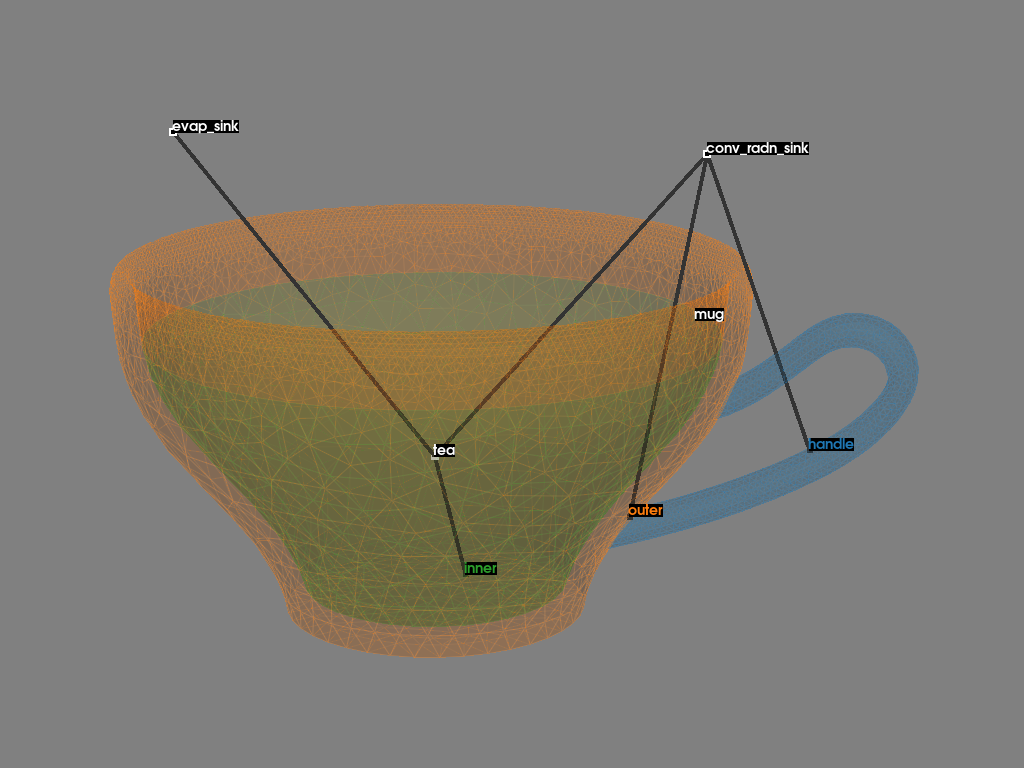

In [6]:
show_thight(model.plot())

### Run the simulation
* Transform the model to executable network model
* Transient simulation

In [7]:
net = Network(model)
sim_period = 15*60
# Increase accuracy because of nonlinear links
result = net.sim([0., sim_period], rel_tol=1e-5)

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.


### Temperature curves
* Choose temperature elements of interest
* Get a pandas dataframe of temperature results
* Plot the dataframe with relevant meta data

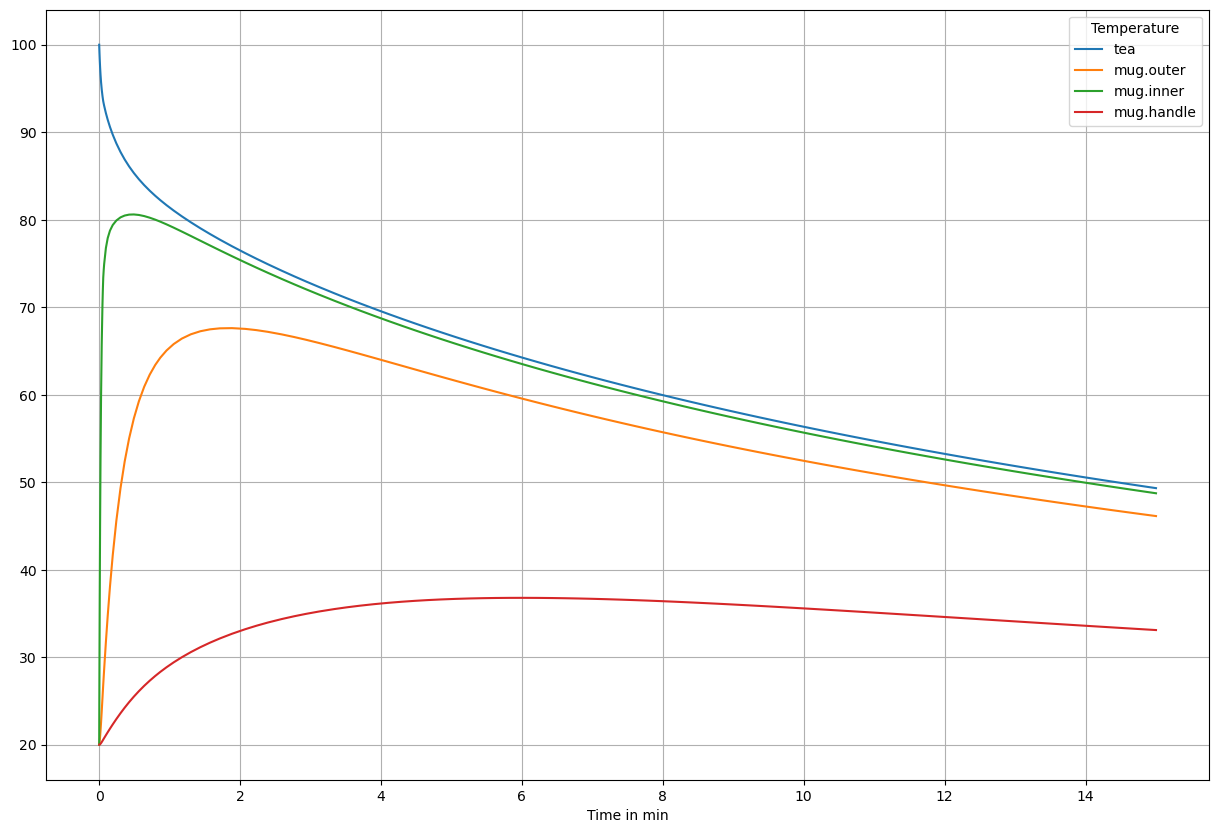

In [8]:
import pandas as pd

temp_df = pd.concat([
    result[tea].temp_frame(),
    result[mug.surf.outer].temp_frame(),
    result[mug.surf.inner].temp_frame(),
    result[mug.surf.handle].temp_frame(),
], axis=1)
temp_df.index /= 60.
temp_df.index.name = 'Time in min'
temp_df.plot(figsize=(15, 10), grid=True);

### Model state after mug capacity is filled up

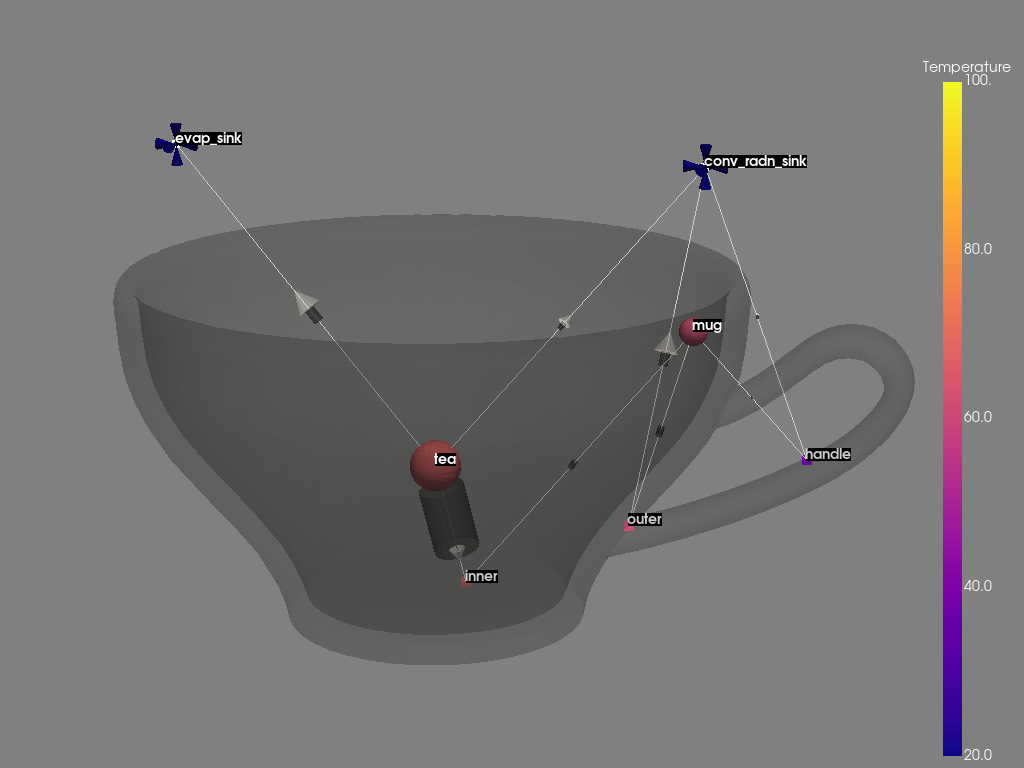

In [9]:
show_thight(result.plot(5*60))

### Model state at beginning

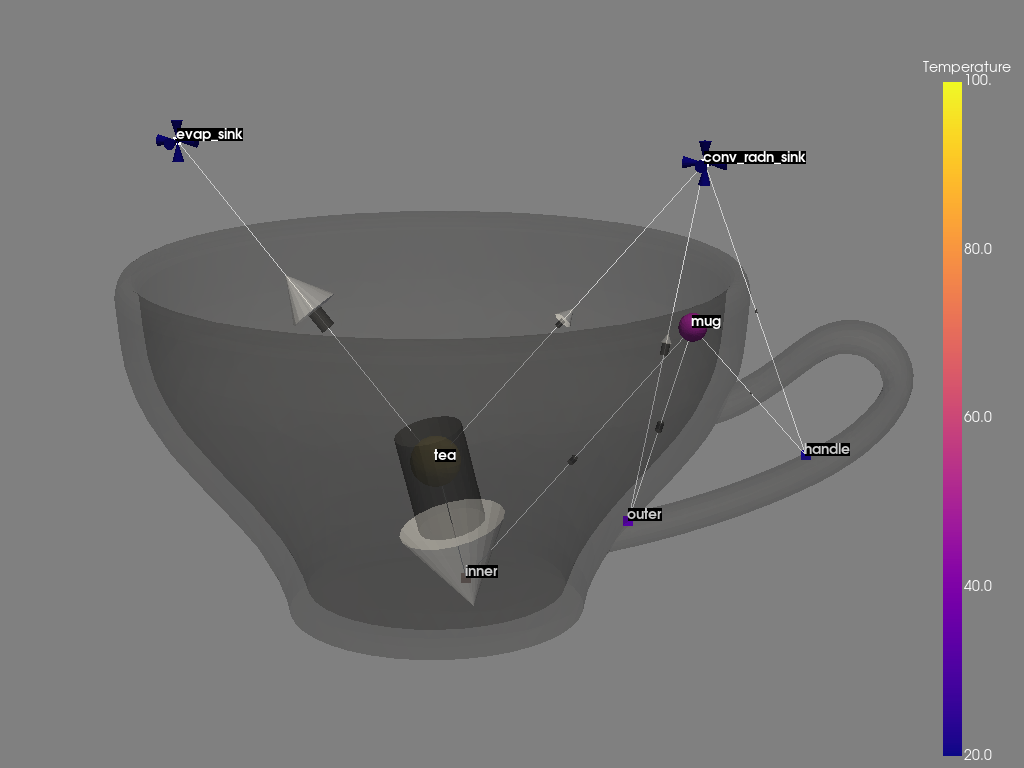

In [10]:
show_thight(result.plot(5))

### Heat flow
* Choose thermal transitions between temperature elements
* Get a pandas dataframe of heat flow results
* Plot the dataframe with relevant meta data

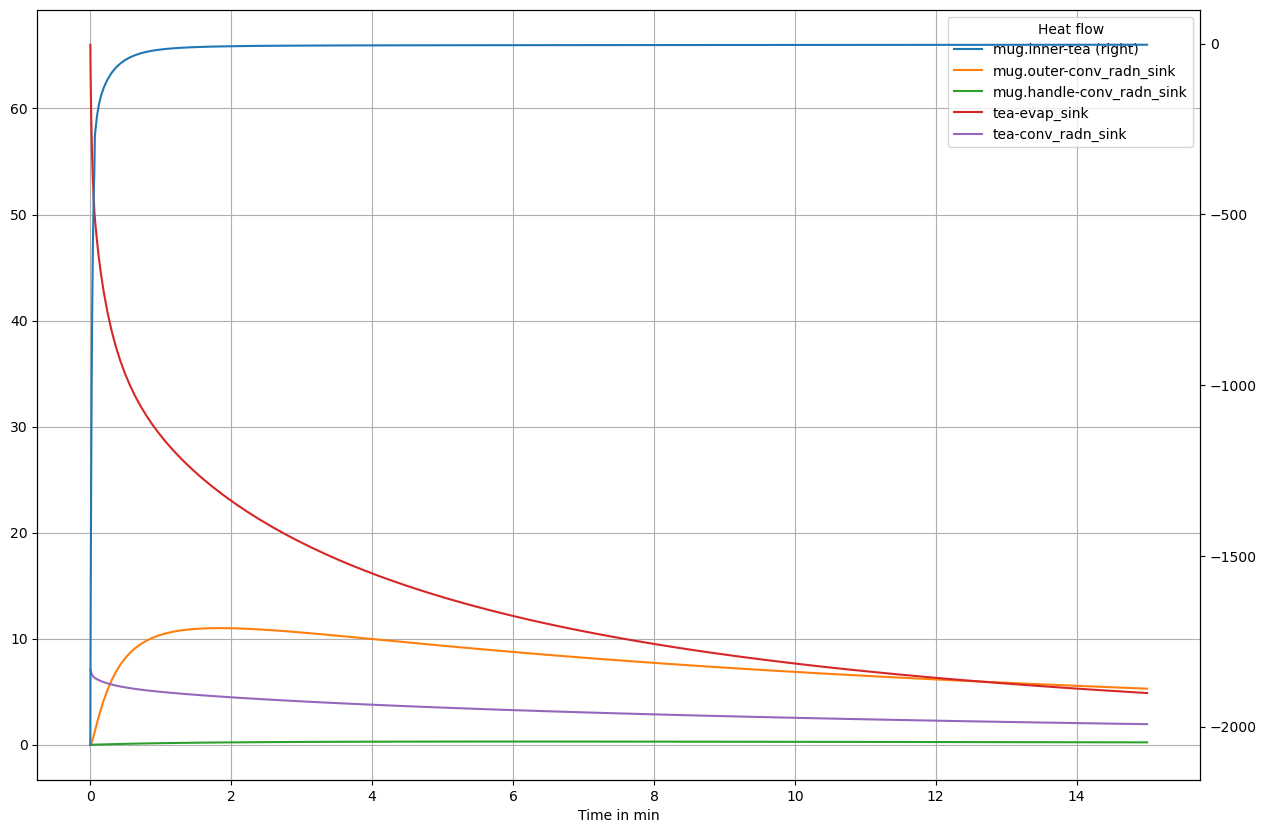

In [11]:
heat_df = pd.concat([
    result[tee_to_mug].heat_frame(),
    result[mug_to_env].heat_frame(),
    result[handle_to_env].heat_frame(),
    result[vap_to_env].heat_frame(),
    result[tee_to_env].heat_frame(),
], axis=1)    
heat_df.index /= 60.
heat_df.index.name = 'Time in min'
heat_df.plot(
    figsize=(15, 10), 
    secondary_y=heat_df.columns[0], 
    grid=True
);

## Compare the full and the order-reduced model

### Simulation speed
* The order-reduced model is way faster than the full FE-model

In [12]:
import time

t_start = time.time()
mor_result = net.sim([0., sim_period], rel_tol=1e-5)
t_mor = time.time() - t_start
print(f"{t_mor=:.2f} seconds")

mug.mor_dof = None
full_net = Network(model)
t_start = time.time()
full_result = full_net.sim([0., sim_period], rel_tol=1e-5)
t_full = time.time() - t_start
print(f"{t_full=:.2f} seconds")
print(f"The order-reduced model is {t_full/t_mor:.0f} times faster!")

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.
t_mor=0.12 seconds
Simulation run progress, speed as sim. time vs. real time:
 0%  7% 14% 22% 30% 37% 45% 53% 60% 68% 76% 83% 91% 99% 100% done.
t_full=30.69 seconds
The order-reduced model is 250 times faster!


### Accuracy

In the present example, there are only small deviations between the model results. The accuracy of the order-reduced model is strongly dependent on the model properties. In certain cases there are significant deviations. Therefore the order-reduced model must always be checked against the full FE-model!

In [13]:
mor_tea_temps = mor_result[tea].temp()
full_tea_temps = full_result[tea].temp(mor_result.time())
print(f"Maximum deviation of tea temperatures: {max(abs(mor_tea_temps - full_tea_temps)):.2f} K")

Maximum deviation of tea temperatures: 0.44 K
